In [1]:
import numpy as np
import polytope as pc
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import OrderedDict

import time
import sys
sys.path.append('../')

from best.mdp import MDP, ParallelMDP
from best.ltl import solve_ltl_cosafe
from best.abstraction import Abstraction

ROVER_STEPS = 15   # rover num of steps
COPTER_STEPS = 30  # copter num of steps
rover_init = np.array([0.5, -4.5])
copter_final = np.array([1.5, -1.5, 2])
copter_init = np.array([-0.5, -4.5, 2])

copter_sight = 2

###### ROVER MODEL (deterministic for now..) ######
rover_abs = Abstraction([-5, -5], [5, 5], [10, 10])
rover = rover_abs.mdp

print rover

Using numpy backend.


MDP: 5 inputs "a" --> 100 outputs "xc"


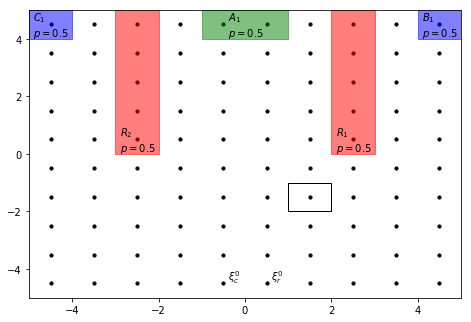

In [2]:
# Define regions
regs = OrderedDict()

regs['r1'] = (pc.box2poly(np.array([[2, 3], [0, 5]])), 0.5, 'red')
regs['r2'] = (pc.box2poly(np.array([[-3, -2], [0, 5]])), 0.5, 'red')
regs['a1'] = (pc.box2poly(np.array([[-1, 1], [4, 5]])), 0.5, 'green')
regs['b1'] = (pc.box2poly(np.array([[4, 5], [4, 5]])), 0.5, 'blue')
regs['c1'] = (pc.box2poly(np.array([[-5, -4], [4, 5]])), 0.5, 'blue')

pinit = [0 if  reg[1] in [0,1] else 2 for reg in regs.itervalues()]

fig = plt.figure()
ax = plt.Axes(fig, [0.,0.,1.,1.])
fig.add_axes(ax)
rover_abs.plot(ax)
          
def plot_region(poly, name, prob, color='red', alpha=0.5, hatch=False, fill=True):
    ax.add_patch(patches.Polygon(pc.extreme(poly), color=color, alpha=alpha, hatch=hatch, fill=fill))
    _, xc = pc.cheby_ball(poly)
    ax.text(xc[0]-0.4, xc[1]-0.43, '${}_{}$\n$p={}$'.format(name[0].upper(), name[1], prob))

for name, info in regs.iteritems():
    plot_region(info[0], name, info[1], info[2])
    
ax.text(rover_init[0]+0.1, rover_init[1]+0.1, '$\\xi_r^0$')

ax.add_patch(patches.Rectangle( copter_final[:2]-0.5, 1, 1, fill=False ))
ax.text(copter_init[0]+0.1, copter_init[1]+0.1, '$\\xi_c^0$')

fig.savefig('arena.pdf')


In [3]:
## Environment belief model
def get_mdp(p0, qw, name):
    # Create map belief MDP with prior p0 and qw quality of weak measurements
    if p0 == 0:
        # no dynamics
        Tnone = np.array([1])
        Tweak = np.array([1])
        Tstrong = np.array([1])
        output_fcn = lambda s: 0
    
    elif p0 == 1:
        Tnone = np.array([1])
        Tweak = np.array([1])
        Tstrong = np.array([1])
        output_fcn = lambda s: 1
        
    else:
        pm = p0/2
        pp = p0 + (1-p0)/2
        # levels [0 p- p0 p+ 1]

        Tnone = np.eye(5);
        Tweak = np.array([[1,           0,             0,       0,              0], 
                          [qw*(1-pm),   (1-qw)*(1-pm), 0,       (1-qw)*pm,      qw*pm],
                          [qw*(1-p0),   (1-qw)*p0,     0,       (1-qw)*(1-p0),  qw*p0],
                          [qw*(1-pp),   (1-qw)*(1-pp), 0,       (1-qw)*pp,      qw*pp],
                          [0,           0,             0,       0,              1]])
        Tstrong = np.array([[1,      0, 0, 0, 0],
                            [(1-pm), 0, 0, 0, pm],
                            [(1-p0), 0, 0, 0, p0],
                            [(1-pp), 0, 0, 0, pp],
                            [0,      0, 0, 0, 1]])

        def output_fcn(s):
            return [0, pm, p0, pp, 1][s]
    
    return MDP([Tnone, Tweak, Tstrong], input_name=name+'_u', output_name=name+'_b', output_fcn=output_fcn)

env = ParallelMDP([get_mdp(info[1], 0, name) for (name, info) in regs.iteritems()])

print env

MDP: 243 inputs "(r1_u, r2_u, a1_u, b1_u, c1_u)" --> 3125 outputs "(r1_b, r2_b, a1_b, b1_b, c1_b)"


In [4]:
## Connect Rover-env
def conn_rov_env(xr):
    ret = [0 for i in range(len(regs))]
    i = 0
    for (name, info) in regs.iteritems():
        poly = info[0]
        if np.all(poly.A.dot(xr) < poly.b + 2):
            ret[i] = 2    # strong measurement
        i += 1
    return set([tuple(ret)])

rover_env_mdp = rover.product(env, connection=conn_rov_env)
print rover_env_mdp

MDP: 5 inputs "a" --> 312500 outputs "(xc, (r1_b, r2_b, a1_b, b1_b, c1_b))"


In [5]:
## Set up LTL problem

formula = '( ( ! fail U sampleA ) & ( ! fail U sampleB ) ) | ( ! fail U ( emptyA & sampleC ) )'

# map ((xc, ry), (e1, ..., en)) -> 2^2^{sampleA, sampleB, fail}
def ltl_connection(xc_env):
    xc = np.array(xc_env[0]).reshape(2,1)
    env = xc_env[1]
    
    i = 0
    
    ret = set([])
    
    for (name, info) in regs.iteritems():
        poly = info[0]
        
        if name[0] == 'r' and poly.contains(xc) and env[i] > 0:
            # we are in risk reg that is not confirmed safe 
            ret |= set(['fail'])
            
        if name[0] == 'a' and poly.contains(xc) and env[i] == 1:
            # we are in target reg with confirmed sample
            ret |= set(['sampleA'])

        if name[0] == 'b' and poly.contains(xc) and env[i] == 1:
            # we are in target reg with confirmed sample
            ret |= set(['sampleB'])

        if name[0] == 'c' and poly.contains(xc) and env[i] == 1:
            # we are in target reg with confirmed sample
            ret |= set(['sampleC'])
        i += 1

    if env[2] == 0:
        # no sample A
        ret |= set(['emptyA'])

    return set([tuple(ret)])

In [6]:
rover_ltlpol = solve_ltl_cosafe(rover_env_mdp, formula, ltl_connection, delta=0.001, maxiter=ROVER_STEPS, verbose=True)

iteration 0, time 3.69548797607e-05
iteration 1, time 7.63988900185
iteration 2, time 14.7954828739
iteration 3, time 21.9950630665
iteration 4, time 29.3089618683
iteration 5, time 36.6072318554
iteration 6, time 43.814499855
iteration 7, time 51.0374350548
iteration 8, time 58.2865178585
iteration 9, time 65.534788847
iteration 10, time 73.0332999229
iteration 11, time 80.483494997
iteration 12, time 87.8676118851
iteration 13, time 95.1027140617
iteration 14, time 102.460357904
finished after 109.972720861s and 15 iterations


success probability: 0.241


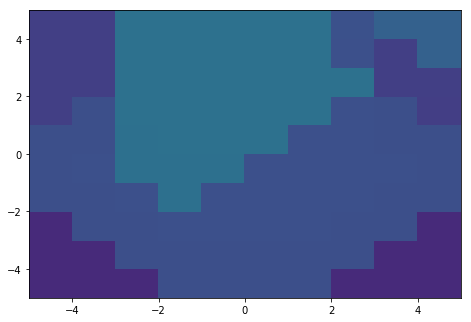

In [7]:
def my_value(x, mapstate):    
    s_abstr = rover_abs.x_to_s(np.array(x).flatten())
    s_tot = rover_env_mdp.global_state( (s_abstr, mapstate) )

    _, val = rover_ltlpol.get_input(s_tot)
    return val

def my_init_value(x, y):
    return my_value(np.array([x, y]), pinit)

fig = plt.figure()
ax = plt.Axes(fig, [0.,0.,1.,1.])
# ax.set_axis_off()
fig.add_axes(ax)

x, y = np.meshgrid(np.arange(-5, 6, 1), np.arange(-5, 6, 1))
xx, yy = np.meshgrid(np.arange(-5, 5, 1), np.arange(-5, 5, 1))
vals = np.vectorize(my_init_value)(xx+0.5, yy+0.5)

ax.pcolor(x, y, vals, vmin=0, vmax=1)

print 'success probability: {}'.format(my_value(rover_init, pinit))

fig.savefig('value-rov.pdf')

In [8]:
# Copter system
copter_abstr = Abstraction([-5, -5, 1.5], [5, 5, 3.5], [10, 10, 2])

copter = copter_abstr.mdp

print copter

# connect copter with map
def is_above(poly, x):
    # return true x within distance 1 of func
    return poly.contains(x.reshape((2,1)))

def is_adjacent(poly, x):
    # return true x within distance 3 of func
    return np.all(poly.A.dot(x) < poly.b + copter_sight)

def copt_env(xr):
    ret = [0 for i in range(len(regs))]
    i = 0
    for (name, info) in regs.iteritems():
        if is_above(info[0], xr[0:2]) and xr[2] < 2.5:
            ret[i] = 2    # strong measurement
        elif is_adjacent(info[0], xr[0:2]) and xr[2] > 2.5:
            ret[i] = 1    # weak measurement
        i += 1
        
    return set([tuple(ret)])

mdp_copt_env = copter.product(env, connection=copt_env)
print mdp_copt_env

MDP: 7 inputs "a" --> 200 outputs "xc"
MDP: 7 inputs "a" --> 625000 outputs "(xc, (r1_b, r2_b, a1_b, b1_b, c1_b))"


In [9]:
# value function at time t: rover success entropy * copter safe
VT = np.zeros(mdp_copt_env.N_list)

init_val = my_value(rover_init, pinit)

for n in range(copter.N):
    if n == copter_abstr.x_to_s(np.array(copter_final)):   # if safe
        for m in range(env.N):
            maps = env.local_states(m)
            v = my_value( rover_init, maps )
            VT[n, m] = max( 2*np.abs(v - 0.5) , 0.5)
            
# run value iteration
Vt_list = [VT]
Polt_list = []

t0 = time.time()
for step in range(COPTER_STEPS):
    print 'step {}, time {}'.format(step, time.time()-t0)

    W_m = mdp_copt_env.sequential_bellman(Vt_list[-1])
    
    Vt_list.append( W_m.max(axis=0) - 0.01 )
    Polt_list.append(W_m.argmax(axis=0))

step 0, time 0.000113010406494
step 1, time 1.66863894463
step 2, time 3.39707398415
step 3, time 5.06595802307
step 4, time 6.72960591316
step 5, time 8.3745880127
step 6, time 10.0013389587
step 7, time 11.6081340313
step 8, time 13.213037014
step 9, time 14.8173429966
step 10, time 16.4211668968
step 11, time 18.0301370621
step 12, time 19.6362788677
step 13, time 21.2566180229
step 14, time 22.8672568798
step 15, time 24.4787709713
step 16, time 26.0802659988
step 17, time 27.6937730312
step 18, time 29.3465180397
step 19, time 30.9646699429
step 20, time 32.5755188465
step 21, time 34.1880719662
step 22, time 35.7943868637
step 23, time 37.4214189053
step 24, time 39.031662941
step 25, time 40.6810040474
step 26, time 42.3377220631
step 27, time 43.9461379051
step 28, time 45.555918932
step 29, time 47.222329855


success value: 0.694671280268


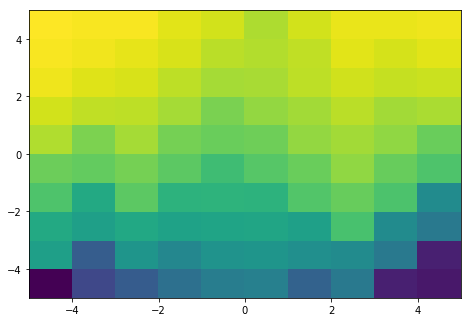

In [10]:
import matplotlib
    
def copter_value(x, mapstate):  
    scop = copter_abstr.x_to_s(x)
    
    nmap = env.global_state(mapstate)

    return Vt_list[-1][scop, nmap]

def my_init_cvalue(x, y):
    return copter_value(np.array([x, y, 2]), pinit)

fig = plt.figure()
ax = plt.Axes(fig, [0.,0.,1.,1.])
# ax.set_axis_off()
fig.add_axes(ax)

x, y = np.meshgrid(np.arange(-5, 6, 1), np.arange(-5, 6, 1))
xx, yy = np.meshgrid(np.arange(-5, 5, 1), np.arange(-5, 5, 1))

vals = np.vectorize(my_init_cvalue)(xx+0.5, yy+0.5)

ax.pcolor(x, y, vals)

print 'success value: {}'.format(copter_value(np.array(copter_init), pinit))

In [11]:
# Control policies

class RoverPolicy:
    
    def __init__(self, ltlpol):
        self.ltlpol = ltlpol
    
    def __call__(self, x, mapstate):
        aps = ltl_connection((x, env.output( env.global_state(mapstate) )))
        rover_ltlpol.report_aps(list(aps)[0])

        s_ab = rover_abs.x_to_s(x)

        s_tot = rover_env_mdp.global_state((s_ab, mapstate))
        u_ab, curr_val = rover_ltlpol.get_input(s_tot)

        return rover_abs.interface(u_ab, s_ab, x)
    
    def finished(self):
        return self.ltlpol.finished()
    
    def reset(self):
        self.ltlpol.reset()    

class CopterPolicy:
    
    def __init__(self, pollist):
        self.pollist = pollist
        self.t = len(pollist)
        self.d_traj = []
        
    def __call__(self, x, mapstate):
        s_ab = copter_abstr.x_to_s(x)

        if len(self.d_traj) == 0 or s_ab != self.d_traj[-1]:
            self.t -= 1
            self.d_traj.append(s_ab)
        
        smap = env.global_state(mapstate)
        
        u_ab = Polt_list[max(0, self.t)][s_ab, smap]
        
        if u_ab == 0:
            # update discrete step
            self.d_traj.append(s_ab)
            self.t -= 1
            
        return copter_abstr.interface(u_ab, s_ab, x).flatten()
    
    def finished(self):
        return self.t <= -1
    
    def reset(self):
        self.t = len(self.pollist)
        self.d_traj = []
        
copter_policy = CopterPolicy(Polt_list)
rover_policy = RoverPolicy(rover_ltlpol)

array([ 0.5, -3.5])

success probability: 0.987
mapstate: [0, 3, 4, 4, 2]
success probability: 0.986
mapstate: [2, 4, 0, 2, 4]
success probability: 0.0
mapstate: [4, 3, 4, 2, 2]
success probability: 0.0
mapstate: [0, 3, 4, 0, 2]


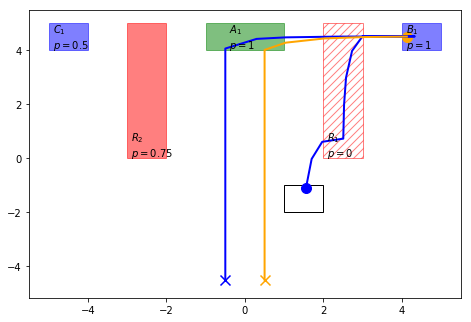

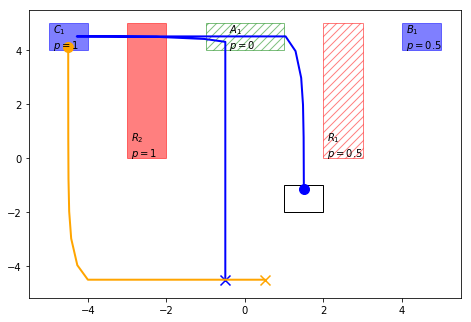

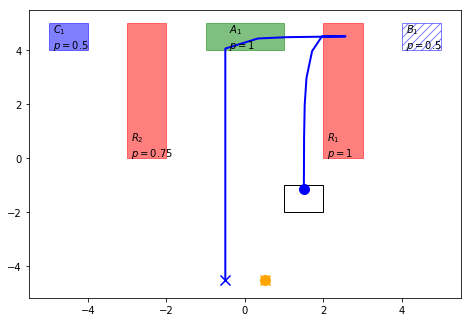

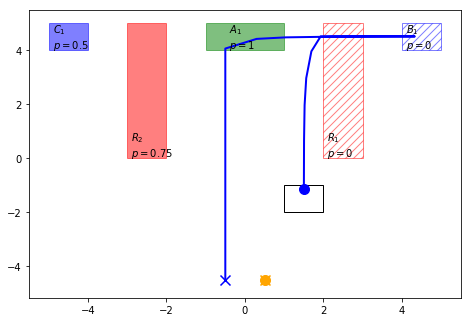

In [29]:
# Simulations

realmaps = ([0, 4, 4, 4, 4], [0, 4, 0, 4, 4], [4, 4, 4, 0, 4], [0, 4, 4, 0, 4])   # true map state

for exp_i in range(len(realmaps)):
    
    realmap = realmaps[exp_i][:]
    
    mapstate = pinit[:]
    
    copter_policy.reset()
    rover_policy.reset()

    # copter simulation
    x_copter = np.array(copter_init).reshape((1,3))
    while not copter_policy.finished():

        x_curr = x_copter[-1, :].flatten()

        map_meas = list(copt_env(x_curr))[0]

        for i in range(len(map_meas)):
            if mapstate[i] in [0, 4]:
                continue
            if map_meas[i] == 1:  # weak meas
                if realmap[i] == 4:
                    mapstate[i] = 3
                else:
                    mapstate[i] = 1
            if map_meas[i] == 2:
                mapstate[i] = realmap[i]

        x_next = copter_policy(x_curr, mapstate)

        x_del = x_curr + 0.1*(x_next - x_curr)/np.linalg.norm(x_next - x_curr)
        x_copter = np.vstack([x_copter, x_del])
        
    print 'success probability: {}'.format(my_value(rover_init, mapstate))
    print 'mapstate: {}'.format(mapstate)
        
    env_probs = env.output(env.global_state(mapstate))

    # rover simulation
    it = 0
    x_rover = np.array(rover_init).reshape((1,2))
    while not rover_policy.finished() and it < 200:
        
        x_curr = x_rover[-1, :].flatten()
        
        map_meas = list(conn_rov_env(x_curr))[0]
        for i in range(len(map_meas)):
            if map_meas[i] == 2:  # strong meas
                mapstate[i] = realmap[i]
        
        x_next = rover_policy(x_curr, mapstate)
        
        if np.linalg.norm(x_next - x_curr) > 0:
            x_del = x_curr + 0.1*(x_next - x_curr)/np.linalg.norm(x_next - x_curr)
        else:
            x_del = x_curr
        x_rover = np.vstack([x_rover, x_del])
        
        it += 1

    fig = plt.figure()
    ax = plt.Axes(fig, [0.,0.,1.,1.])
    fig.add_axes(ax)
    
    i = 0
    for (name, info) in regs.iteritems():
        if realmap[i] == 0:
            hatch = '///'
            fill = False
        else:
            hatch = False
            fill = True
        plot_region(info[0], name, env_probs[i], info[2], hatch=hatch, fill=fill)
        i += 1

    ax.plot(x_copter[:, 0], x_copter[:, 1], color='blue', linewidth=2)
    ax.scatter(x_copter[0, 0], x_copter[0, 1], marker='x', color='blue', zorder=2, s=100)
    ax.scatter(x_copter[-1, 0], x_copter[-1, 1], marker='o', color='blue', zorder=2, s=100)

    ax.plot(x_rover[:, 0], x_rover[:, 1], color='orange', linewidth=2)
    ax.scatter(x_rover[0, 0], x_rover[0, 1], marker='x', color='orange', zorder=2, s=100)
    ax.scatter(x_rover[-1, 0], x_rover[-1, 1], marker='o', color='orange', zorder=2, s=100)

    ax.add_patch(patches.Rectangle( copter_final[:2]-0.5, 1, 1, fill=False ))

    fig.savefig('exp{}-map.pdf'.format(exp_i))
    
